In [1]:
!git clone https://github.com/Omidzarexz/AnkleBiLSTMJointPrediction


Cloning into 'AnkleBiLSTMJointPrediction'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 206 (delta 45), reused 14 (delta 14), pack-reused 129 (from 1)
Receiving objects: 100% (206/206), 27.42 MiB | 13.44 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [29]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


# df_clean_train_12feature_cross_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_12feature_cross_subject.csv")
# df_clean_test_12feature_cross_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_12feature_cross_subject.csv")


df_clean_train_16feature_cross_subject = pd.read_csv("/kaggle/working/AnkleBiLSTMJointPrediction/preprocessed_data/df_clean_train_16feature_cross_subject.csv")
df_clean_test_16feature_cross_subject  = pd.read_csv("/kaggle/working/AnkleBiLSTMJointPrediction/preprocessed_data/df_clean_test_16feature_cross_subject.csv")


# df_clean_train_16feature_within_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_16feature_within_subject_txt25.csv")
# df_clean_test_16feature_within_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_16feature_within_subject_txt25.csv")

df_clean_train = df_clean_train_16feature_cross_subject
df_clean_test  = df_clean_test_16feature_cross_subject

In [30]:
from scipy.signal import butter, filtfilt

def low_pass_butter(signal, cutoff=10, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)
feature_columns = [
    'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
    'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    'MPU1_Roll','MPU1_Pitch',
    'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
    'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z',
    'MPU2_Roll','MPU2_Pitch'
]




df_filtered_trainig = pd.DataFrame()
df_filtered_test    = pd.DataFrame()
for col in feature_columns:
    df_filtered_trainig[col] = low_pass_butter( df_clean_train[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )
    df_filtered_test[col] = low_pass_butter( df_clean_test[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )







print("\ndf_filtered_trainig shape:",df_filtered_trainig.shape)
print("\ndf_filtered_test shape:",df_filtered_test.shape)



df_filtered_trainig shape: (87394, 16)

df_filtered_test shape: (17492, 16)


In [31]:

from sklearn.preprocessing import  MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1, 1))
X_data_train = scaler.fit_transform(df_filtered_trainig[feature_columns].values)  # (T, 12)


y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_data_train = y_scaler.fit_transform(df_clean_train['angle'].values.reshape(-1, 1))





X_data_test = scaler.transform(df_filtered_test[feature_columns].values)

y_data_test = y_scaler.transform(df_clean_test["angle"].values.reshape(-1,1))


# تنظیمات پنجره
window_size = 200   #
horizon = 20        #
step_size = 20      #

# تابع پنجره‌بندی
def create_windows_with_labels(X, y, window_size, horizon, step_size):
    X_windows = []
    y_windows = []
    for i in range(0,  len(X) - window_size - horizon + 1, step_size):
        X_windows.append(X[i:i + window_size])
        y_windows.append(y[i + window_size : i + window_size + horizon])  # برچسب آخرین نمونه در پنجره
    return np.array(X_windows), np.array(y_windows)

# ایجاد پنجره‌ها
X_windows, y_windows = create_windows_with_labels(X_data_train, y_data_train,
                                                  window_size, horizon, step_size)
if horizon==1:
    y_windows = y_windows.reshape(-1,1)
else:
    y_windows = np.squeeze(y_windows, axis=2)





print(f"✅   (X_windows):(samples, time steps, features) → {X_windows.shape}")
print(f"✅  (y_windows): {y_windows.shape}")

step_size_for_test = 1
X_windows_test, y_windows_test = create_windows_with_labels(X_data_test, y_data_test,
                                                            window_size, horizon, step_size_for_test)

if horizon==1:
    y_windows_test = y_windows_test.reshape(-1,1)
else:
    y_windows_test = np.squeeze(y_windows_test, axis=2)

print(f"\n✅   (X_windows_test):(samples, time steps, features) → {X_windows_test.shape}")
print(f"✅  (y_windows_test): {y_windows_test.shape}")






✅   (X_windows):(samples, time steps, features) → (4359, 200, 16)
✅  (y_windows): (4359, 20)

✅   (X_windows_test):(samples, time steps, features) → (17273, 200, 16)
✅  (y_windows_test): (17273, 20)


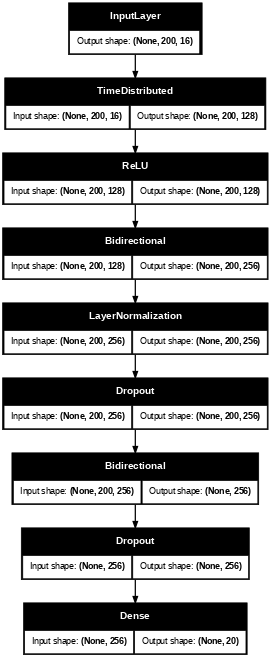

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Bidirectional

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, Dropout, ReLU, TimeDistributed, LayerNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

LEARNING_RATE = 0.001
lambda_loss_amount = 0.0005



def build_bi_lstm_model(input_shape, horizon=1, lambda_loss_amount=1e-4, learning_rate=1e-3):
    inputs = Input(shape=input_shape, name="input")

    # Dense projection per timestep
    x = TimeDistributed(Dense(128, kernel_regularizer=l2(lambda_loss_amount)))(inputs)
    x = ReLU()(x)

    # Stacked BiGRU layers
    x = Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=l2(lambda_loss_amount)))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(128, return_sequences=False,
                           kernel_regularizer=l2(lambda_loss_amount)))(x)
    x = Dropout(0.3)(x)

    # Output
    outputs = Dense(horizon, activation='linear')(x)

    # Model compile
    model = Model(inputs=inputs, outputs=outputs, name="BiLSTM_reg")
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

final_model = build_bi_lstm_model(input_shape=(X_windows.shape[1],X_windows.shape[2]),horizon=horizon)

# final_model.summary()

plot_model(final_model, show_shapes=True , dpi=45)

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split( X_windows, y_windows, test_size=0.2,
                                                   shuffle=False, random_state=42)


callbacks = [
    ModelCheckpoint('best_lstm_model_reg.keras', save_best_only=True, monitor='val_loss',verbose=1),
    EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=5e-6,verbose=1)
]

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2493 - mae: 0.2811
Epoch 1: val_loss improved from inf to 0.12081, saving model to best_lstm_model_reg.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - loss: 0.2481 - mae: 0.2799 - val_loss: 0.1208 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1204 - mae: 0.1469
Epoch 2: val_loss improved from 0.12081 to 0.09579, saving model to best_lstm_model_reg.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.1203 - mae: 0.1468 - val_loss: 0.0958 - val_mae: 0.1305 - learning_rate: 0.0010
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0931 - mae: 0.1269
Epoch 3: val_loss improved from 0.09579 to 0.08207, saving model to best_lstm_model_reg.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0930 - mae: 0.1269 - val_loss: 0.0821 - val_mae: 0.1268 - learning_rate: 0.0010
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0744 - mae: 0.1089
Epoch 

In [37]:
from tensorflow.keras.models import load_model
from sklearn.metrics import  mean_absolute_error

# model  = load_model("/kaggle/input/m/tensorflow2/default/1/best_lstm_model_reg.keras")
# پیش‌بینی روی داده تست-
y_pred_scaled = final_model.predict(X_windows_test)  # (N, 1)

# برگرداندن به مقیاس اصلی
y_pred_original = y_scaler.inverse_transform(y_pred_scaled)
y_true_original = y_scaler.inverse_transform(y_windows_test)




mae = mean_absolute_error(y_true_original, y_pred_original)
mae2 = mean_absolute_error(y_windows_test, y_pred_scaled)

print(f"Test MAE(scaled): {mae2:.3f}")
print(f"Test MAE(true value): {mae:.3f}")


540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step
Test MAE(scaled): 0.114
Test MAE(true value): 2.380


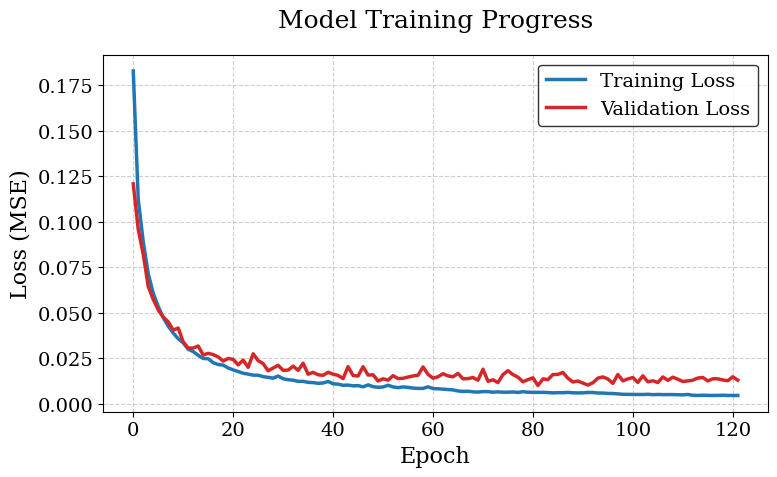

In [38]:
import matplotlib.pyplot as plt

# Set font sizes and styles for publication
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',  # Optional: use serif font (common in papers)
    'figure.figsize': (8, 5)
})

# Plot training & validation loss
plt.plot(history.history["loss"], label="Training Loss", linewidth=2.5, color='tab:blue')
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2.5, color='tab:red')

# Add title and axis labels
plt.title("Model Training Progress", fontsize=18, pad=20)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

# Improve layout and add grid
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(frameon=True, loc='upper right', shadow=False, edgecolor='black')

# Use tight layout to prevent clipping
plt.tight_layout()

# Save high-resolution figure for your article
plt.savefig("training_validation_loss.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("training_validation_loss.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [40]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [9]:
y_true_original.shape

(16793, 100)

In [10]:
y_pred_original.shape

(16793, 100)

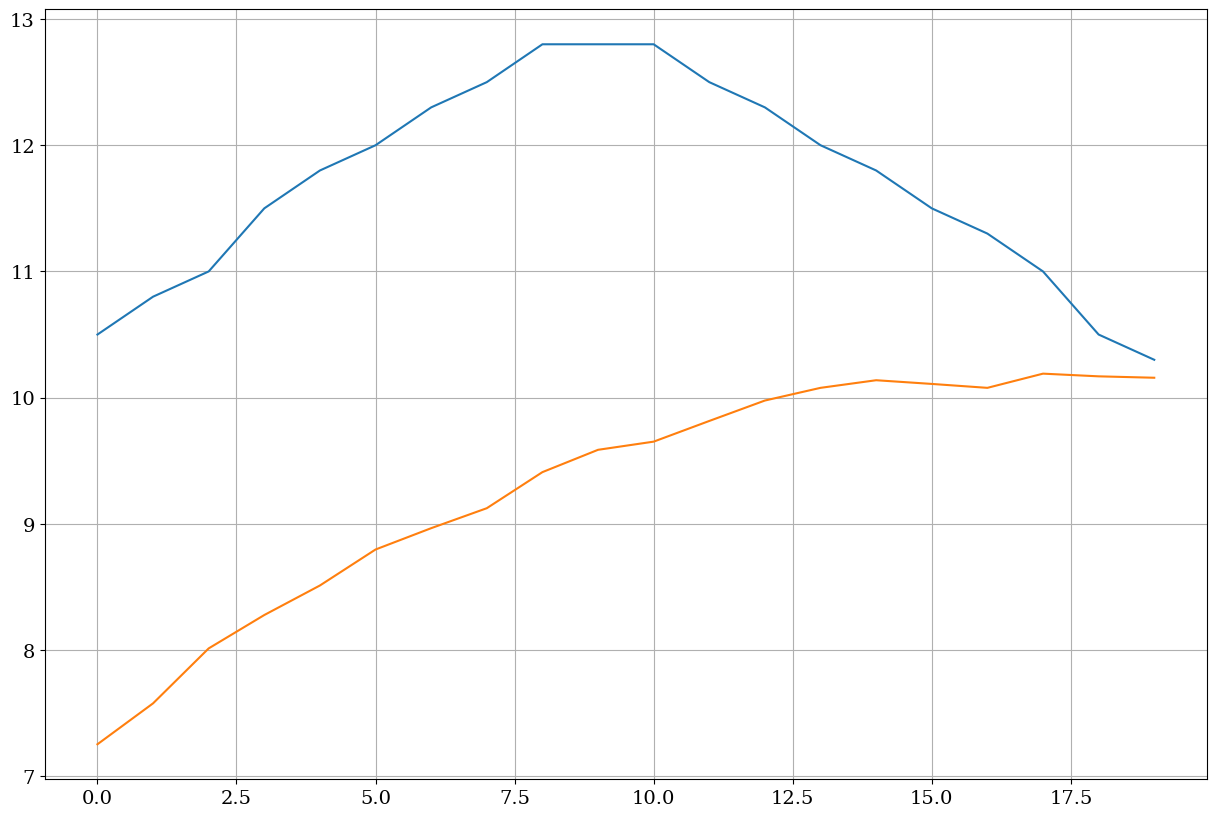

In [41]:


# time = np.arange(1, y_true_original.shape[0]+1) * 0.01
# time = time.reshape(-1, 1)

n1=9200
n2=9900
plt.figure(figsize=(15,10))
plt.plot(y_true_original[222,:])
plt.plot(y_pred_original[222,:])
plt.grid()

